# Lab 8: Correlation, Variance of Sample Means

Welcome to Lab 8!

In today's lab, we will learn about [the variance of sample means](https://www.inferentialthinking.com/chapters/14/5/variability-of-the-sample-mean.html) as well as ways to understand and quantify [the association between two variables](https://www.inferentialthinking.com/chapters/15/1/correlation.html).

In [4]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
import pandas as pd

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('seaborn')
import warnings
warnings.simplefilter('ignore', FutureWarning)




# 1. How Faithful is Old Faithful? 

(Note: clever title comes from [here](http://web.pdx.edu/~jfreder/M212/oldfaithful.pdf).)

Old Faithful is a geyser in Yellowstone National Park in the central United States.  It's famous for erupting on a fairly regular schedule.  You can see a video below.

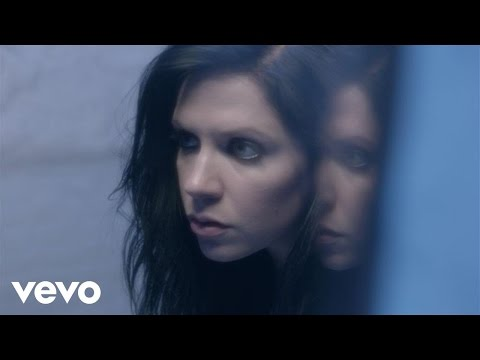

In [6]:
# For the curious: this is how to display a YouTube video in a
# Jupyter notebook.  The argument to YouTubeVideo is the part
# of the URL (called a "query parameter") that identifies the
# video.  For example, the full URL for this video is:
#   https://www.youtube.com/watch?v=wE8NDuzt8eg
from IPython.display import YouTubeVideo
YouTubeVideo("k2WcOdz96ko")
##KFLAY

Some of Old Faithful's eruptions last longer than others.  When it has a long eruption, there's generally a longer wait until the next eruption.

If you visit Yellowstone, you might want to predict when the next eruption will happen, so you can see the rest of the park and come to see the geyser when it happens.  Today, we will use a dataset on eruption durations and waiting times to see if we can make such predictions accurately with linear regression.

The dataset has one row for each observed eruption.  It includes the following columns:
- **duration**: Eruption duration, in minutes.
- **wait**: Time between this eruption and the next, also in minutes.

Run the next cell to load the dataset.

In [9]:
faithful = pd.read_csv("faithful.csv")
faithful.head()

,duration,wait
0,3.600,79.0
1,1.800,54.0
2,3.333,74.0
3,2.283,62.0
4,4.533,85.0


We would like to use linear regression to make predictions, but that won't work well if the data aren't roughly linearly related.  To check that, we should look at the data.

#### Question 1
Make a scatter plot of the data.  It's conventional to put the column we will try to predict on the vertical axis and the other column on the horizontal axis.

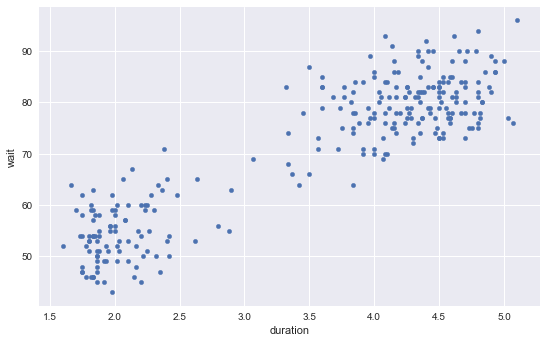

In [17]:
faithful.plot.scatter(0,1)

#### Question 2
Look at the scatter plot. Are eruption duration and waiting time roughly linearly related?  Is the relationship positive, as we claimed earlier?  You may want to consult this [section](https://www.inferentialthinking.com/chapters/15/prediction.html) of the textbook for the definition of a linear association.

HEck yeah it is!

We're going to continue with the provisional assumption that they are linearly related, so it's reasonable to use linear regression to analyze this data.

We'd next like to plot the data in standard units.  Recall that, if `nums` is an array of numbers, then

    (nums - np.mean(nums)) / np.std(nums)

is an array of those numbers in standard units.

#### Question 3
Compute the mean and standard deviation of the eruption durations and waiting times.  **Then**, create a table called `faithful_standard` containing the eruption durations and waiting times in standard units.  (The columns should be named `"duration (standard units)"` and `"wait (standard units)"`.

In [28]:
duration_mean = np.mean(faithful.duration)
duration_std = np.std(faithful.duration)
wait_mean = np.mean(faithful.wait)
wait_std = np.std(faithful.wait)

faithful_dict = {"duration (standard units)": (faithful.duration - duration_mean)/duration_std, \
                 "wait (standard units)":(faithful.wait - wait_mean)/wait_std }


faithful_standard = pd.DataFrame(faithful_dict)

faithful_standard.head()

,duration (standard units),wait (standard units)
0,0.098499,0.597123
1,-1.481459,-1.245181
2,-0.135861,0.228663
3,-1.057503,-0.655644
4,0.917443,1.039277


In [ ]:
_ = ok.grade('q1_3')

#### Question 4
Plot the data again, but this time in standard units.

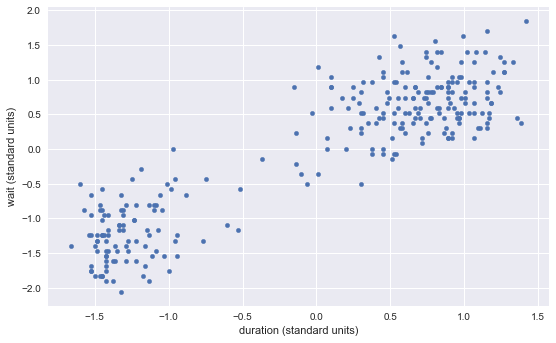

In [30]:
faithful_standard.plot.scatter(0, 1)

You'll notice that this plot looks exactly the same as the last one!  The data really are different, but the axes are scaled differently.  (The method `scatter` scales the axes so the data fill up the available space.)  So it's important to read the ticks on the axes.

#### Question 5
Among the following numbers, which would you guess is closest to the correlation between eruption duration and waiting time in this dataset?

* -1
* 0
* 1

1

#### Question 6
Compute the correlation `r`.  *Hint:* Use `faithful_standard`.  This [section](https://www.inferentialthinking.com/chapters/15/1/correlation.html) on correlation explains how to do this.

In [38]:
r = np.mean(faithful_standard["duration (standard units)"]* faithful_standard["wait (standard units)"])
r

0.9008111683218134

In [43]:
np.corrcoef(faithful_standard["duration (standard units)"], faithful_standard["wait (standard units)"])

array([[1.        , 0.90081117],
       [0.90081117, 1.        ]])

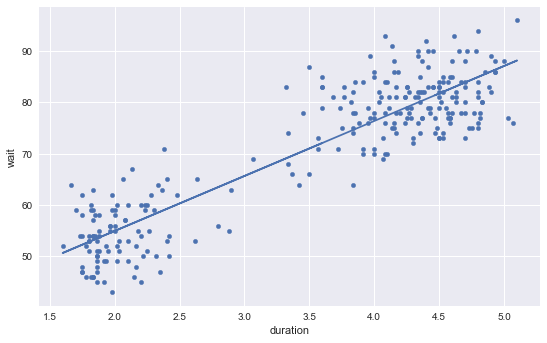

In [68]:
m = r * wait_std/duration_std
b = wait_mean - m * duration_mean
faithful.plot.scatter(0,1)
plots.plot(faithful.duration, m*faithful.duration + b)

# 2. Variability of the Sample Mean

By the Central Limit Theorem, the probability distribution of the mean of a large random sample is roughly normal. The bell curve is centered at the population mean. Some of the sample means are higher and some are lower, but the deviations from the population mean are roughly symmetric on either side, as we have seen repeatedly. Formally, probability theory shows that the sample mean is an unbiased estimate of the population mean.

In our simulations, we also noticed that the means of larger samples tend to be more tightly clustered around the population mean than means of smaller samples. In this section, we will quantify the variability of the sample mean and develop a relation between the variability and the sample size.

Let's take a look at the salaries of employees of the City of San Francisco in 2014. The mean salary reported by the city government was about $75463.92.

In [ ]:
salaries = Table.read_table('sf_salaries_2014.csv').select("salary")
salaries

In [ ]:
salary_mean = np.mean(salaries.column('salary'))
salary_mean

In [ ]:
salaries.hist('salary', bins=np.arange(0, 300000+10000*2, 10000))
plots.scatter(salary_mean, 0, marker='^', color='red', s=100);

#### Question 1

Clearly, the population does not follow a normal distribution. Keep that in mind as we progress through these exercises.

Let's take random samples and look at the probability distribution of the sample mean. As usual, we will use simulation to get an empirical approximation to this distribution.

We will define a function `simulate_sample_mean` to do this, because we are going to vary the sample size later. The arguments are the name of the table, the label of the column containing the variable, the sample size, and the number of simulations.

In [ ]:
"""Empirical distribution of random sample means"""

def simulate_sample_mean(table, label, sample_size, repetitions):
    
    means = make_array()

    for i in np.arange(repetitions):
        new_sample = ...
        new_sample_mean = ...
        means = ...

    sample_means = Table().with_column('Sample Means', means)
    
    # Display empirical histogram and print all relevant quantities – don't change this!
    sample_means.hist(bins=20)
    plots.xlabel('Sample Means')
    plots.title('Sample Size ' + str(sample_size))
    print("Sample size: ", sample_size)
    print("Population mean:", np.mean(table.column(label)))
    print("Average of sample means: ", np.mean(means))
    print("Population SD:", np.std(table.column(label)))
    print("SD of sample means:", np.std(means))

Verify with your neighbor or TA that you've implemented the above function correctly. If you haven't implemented it correctly, the rest of the lab won't work properly, so this step is crucial.

#### Question 2

In the following cell, we will create a sample of size 100 from the salaries table and graph it using our new `simulate_sample_mean` function.

In [ ]:
simulate_sample_mean(salaries, 'salary', 100, 10000) 
plots.xlim(50000, 100000)

In the following two cells, simulate the mean of a random sample of 400 salaries and 625 salaries, respectively. In each case, perform 10,000 repetitions of each of these processes. Don't worry about the `plots.xlim` line – it just makes sure that all of the plots have the same x-axis. 

In [ ]:
simulate_sample_mean(..., ..., ..., ...)
plots.xlim(50000, 100000)

In [ ]:
simulate_sample_mean(..., ..., ..., ...)
plots.xlim(50000, 100000)

Write your conclusions about what you just saw in the below cell.

**Conclusions:** 

#### Question 3

Assign the variable `bootstrap_sampled_SD` to the integer corresponding to your answer to the following question:

When I increase the number of bootstrap samples that I take, for a fixed sample size, the SD of my sample mean will...

1. Increase
2. Decrease
3. Stay about the same
4. Vary widly

In [ ]:
bootstrap_sampled_SD = ...

In [ ]:
ok.grade('q2_3');

Below, we'll look at what happens when we take a fixed sample, then bootstrap from it with different numbers of resamples. How does the distribution of the resampled means change?

In [ ]:
simulate_sample_mean(salaries, 'salary', 100, 500)
plots.xlim(50000, 100000)

In [ ]:
simulate_sample_mean(salaries, 'salary', 100, 1000)
plots.xlim(50000, 100000)

In [ ]:
simulate_sample_mean(salaries, 'salary', 100, 5000)
plots.xlim(50000, 100000)

In [ ]:
simulate_sample_mean(salaries, 'salary', 100, 10000)
plots.xlim(50000, 100000)

What did you notice about the sample means of the four bootstrapped samples above? Discuss with your neighbors. If you're unsure of your conclusion, ask your TA.

#### Question 4
Let's think about how the relationships between population SD, sample SD, and SD of sample means change with varying sample size. Which of the following is true? Again, assign the variable `pop_vs_sample` to the integer corresponding to your answer.

1. Sample SD gets smaller with increasing sample size, SD of sample means gets smaller with increasing sample size
2. Sample SD gets larger with increasing sample size, SD of sample means stays the same with increasing sample size
3. Sample SD becomes more consistent with population SD with increasing sample size, SD of sample means gets smaller with increasing sample size
4. Sample SD becomes more consistent with populatoin SD with increasing sample size, SD of smaple means stays the same with increasing sample size

In [ ]:
pop_vs_sample = ...

In [ ]:
ok.grade('q2_4');

Let's see what happens: First, we calculate the population SD so that we can compare the SD of each sample to the SD of the population.

In [ ]:
pop_sd = np.std(salaries.column("salary"))
pop_sd

Let's then how a small sample behaves. Run the following cells multiple times to see how the SD of the sample changes from sample to sample. Adjust the bins as necessary.

In [ ]:
sample_10 = salaries.sample(10)
sample_10.hist("salary")
print("Sample SD: ", np.std(sample_10.column("salary")))
simulate_sample_mean(sample_10, 'salary', 10, 1000)
plots.xlim(5,120000)
plots.ylim(0, .0001);

In [ ]:
sample_200 = salaries.sample(200)
sample_200.hist("salary")
print("Sample SD: ", np.std(sample_200.column("salary")))
simulate_sample_mean(sample_200, 'salary', 200, 1000)
plots.xlim(5,100000)
plots.ylim(0, .00015);

In [ ]:
sample_1000 = salaries.sample(1000)
sample_1000.hist("salary")
print("Sample SD: ", np.std(sample_1000.column("salary")))
simulate_sample_mean(sample_1000, 'salary', 1000, 1000)
plots.xlim(5,100000)
plots.ylim(0, .00025);

Let's illustrate this trend. Below, you will see how the average absolute error of SD from the population changes with sample size (N).

In [ ]:
# Don't change this cell, just run it!
sample_n_errors = make_array()
for i in np.arange(10, 200, 10):
    sample_n_errors = np.append(sample_n_errors, np.average([abs(np.std(salaries.sample(i).column("salary"))-pop_sd)
                                                      for d in np.arange(100)]))
Table().with_column("Average absolute error in SD", sample_n_errors, "N", np.arange(10, 200, 10)).plot("N", "Average absolute error in SD")

You should notice that the distribution of means gets spiker, and that the distribution of the sample increasingly looks like the distribution of the population as we get to larger sample sizes. 

Is there a relationship between the sample size and absolute error in standard deviation? Identify this relationship – if you're having trouble, take a look at this [section](https://www.inferentialthinking.com/chapters/12/5/variability-of-the-sample-mean.html) in our textbook about the variability of sample means.

That's it! You've completed Lab 8. There weren't many tests, but there were a lot of points at which you should've stopped and understood exactly what was going on. Consult the textbook or ask your GSI if you have any other questions!

Be sure to 
- **run all the tests** (the next cell has a shortcut for that), 
- **Save and Checkpoint** from the `File` menu,
- **run the last cell to submit your work**,
- and ask one of the staff members to check you off.

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
val = lambda q: q.startswith('q1') or q.startswith('q2_3') or q.startswith('q2_4')
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if val(q)]
print("Finished running all tests.")

In [ ]:
# Run this cell to submit your work *after* you have passed all of the test cells.
# It's ok to run this cell multiple times. Only your final submission will be scored.

_ = ok.submit()